In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from data_processing.cgm_data import CGMData, DATA_PATH

Copying the next several cells from GoodResults to ensure files are being read properly:

In [2]:
food = pd.read_csv(f'./{DATA_PATH}/001/Food_Log_001.csv', index_col=['time_begin'], parse_dates=['time_begin'], skipinitialspace=True)

In [3]:
glu = pd.read_csv(f'./{DATA_PATH}/001/Dexcom_001.csv', header=0, skiprows=range(1, 13), index_col=['Timestamp (YYYY-MM-DDThh:mm:ss)'], parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'])

In [6]:
food2 = pd.read_csv(f'./{DATA_PATH}/002/Food_Log_002.csv', index_col=['time_begin'], parse_dates=['time_begin'], skipinitialspace=True)
glu2 = pd.read_csv(f'./{DATA_PATH}/002/Dexcom_002.csv', header=0, skiprows=range(1, 13), index_col=['Timestamp (YYYY-MM-DDThh:mm:ss)'], parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'])

In [8]:
data = CGMData()
print(data[1].gender)
print(data[1].hba1c)
# print(data[1].glu.head(5))

FEMALE
5.5


In [9]:
# Verifying all datasets load properly
for i in range(2, 3):
  for data_str in ['acc', 'bvp', 'glu', 'eda', 'food', 'hr', 'ibi', 'temp']:
    print(i, data_str)
    try:
      print(data[i].__getattribute__(data_str).head(5))
    except Exception as e:
      print(f"Error on patient {i} with {data_str}: {e}")

2 acc
Error on patient 2 with acc: Pandas requires version '10.0.1' or newer of 'pyarrow' (version '3.0.0' currently installed).
2 bvp
Error on patient 2 with bvp: Pandas requires version '10.0.1' or newer of 'pyarrow' (version '3.0.0' currently installed).
2 glu
                     glucose
datetime                    
2020-02-21 11:08:36    186.0
2020-02-21 11:13:36    181.0
2020-02-21 11:18:36    175.0
2020-02-21 11:23:35    168.0
2020-02-21 11:28:36    163.0
2 eda
Error on patient 2 with eda: Pandas requires version '10.0.1' or newer of 'pyarrow' (version '3.0.0' currently installed).
2 food
                    time_end                   logged_food  amount  \
time_begin                                                           
2020-02-21 10:09:00      NaT                   Mello Yello    12.0   
2020-02-21 10:11:00      NaT  (Jimmy Dean) Chicken Biscuit     1.0   
2020-02-21 12:09:00      NaT                    Beef Jerky     2.0   
2020-02-21 12:12:00      NaT       (Gatorade) F

In [10]:
# Get the curve immediately after food consumption
def get_meal_spike(glu, time, duration):
  # get a slice of glu for duration hours after time
  glu_slice = glu.loc[time:time + pd.Timedelta(hours=duration), 'glucose']
  glu_slice.index = glu_slice.index - glu_slice.index[0]
  # sometimes the measurements are off by a second
  glu_slice.index = glu_slice.index.round(freq='5min')
  return glu_slice

In [11]:
slices = []
for start in food.index:
  slices.append(get_meal_spike(data[1].glu, start, 3))

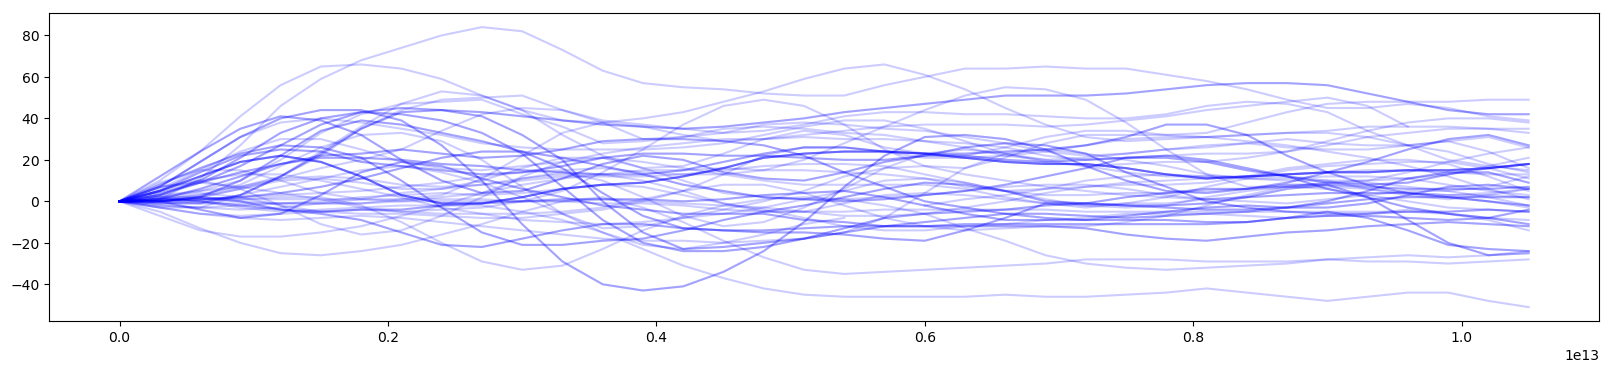

In [19]:
# Meals from patient 1, start aligned
df = pd.concat(slices, axis=1)
df.columns = list(range(df.shape[1]))

plt.figure(figsize=(20, 4))
for col in range(df.shape[1]):
  plt.plot(df[col] - df.iloc[0, col], color='blue', alpha=0.2)

In [13]:
def find_standard_meal(df):
  bfast_filter = df['searched_food'].str.contains('Partly Skimmed Milk') | df['searched_food'].str.contains('Frosted Flakes')
  return df[bfast_filter]

In [16]:
find_standard_meal(data[2].food)

,time_end,logged_food,amount,unit,searched_food,calorie,total_carb,dietary_fiber,sugar,protein,total_fat
time_begin,,,,,,,,,,,
2020-02-22 05:39:00,NaT,Natrel Lactose Free 2 Percent,8.00,fluid ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,120.0,9.0,NaN,8.0,12.0,NaN
2020-02-22 05:39:00,NaT,Corn Flakes,0.75,cup,"(Kellogg's) Frosted Flakes, Cereal",110.0,26.0,NaN,10.0,1.0,NaN
2020-02-24 09:30:00,NaT,Natrel Lactose Free 2 Percent,8.00,fluid ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,120.0,9.0,NaN,8.0,12.0,NaN
2020-02-24 09:30:00,NaT,Corn Flakes,0.75,cup,"(Kellogg's) Frosted Flakes, Cereal",110.0,26.0,NaN,10.0,1.0,NaN
2020-02-26 10:05:00,NaT,Natrel Lactose Free 2 Percent,8.00,fluid ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,120.0,9.0,NaN,8.0,12.0,NaN
2020-02-26 10:05:00,NaT,Corn Flakes,0.75,cup,"(Kellogg's) Frosted Flakes, Cereal",110.0,26.0,NaN,10.0,1.0,NaN
2020-02-28 08:37:00,NaT,Natrel Lactose Free 2 Percent,8.00,fluid ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,120.0,9.0,NaN,8.0,12.0,NaN
2020-02-28 08:37:00,NaT,Corn Flakes,0.75,cup,"(Kellogg's) Frosted Flakes, Cereal",110.0,26.0,NaN,10.0,1.0,NaN


Things we need for regression of "peak glucose during interval between meals" and "glucose reading at time of meal, protein, carbs, fat

In [27]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
datetime,,,,,,,,,,,,,,,,,,,,,
0 days 02:35:00,104.0,111.0,111.0,91.0,91.0,92.0,93.0,93.0,132.0,112.0,...,142.0,148.0,96.0,96.0,97.0,117.0,117.0,128.0,132.0,139.0
0 days 02:40:00,106.0,110.0,110.0,95.0,95.0,94.0,94.0,94.0,125.0,113.0,...,146.0,146.0,95.0,95.0,101.0,106.0,106.0,130.0,132.0,129.0
0 days 02:45:00,104.0,110.0,110.0,99.0,99.0,94.0,95.0,95.0,118.0,113.0,...,148.0,144.0,94.0,94.0,106.0,95.0,95.0,132.0,130.0,NaN
0 days 02:50:00,100.0,110.0,110.0,100.0,100.0,96.0,94.0,94.0,115.0,114.0,...,148.0,141.0,95.0,95.0,110.0,89.0,89.0,132.0,124.0,NaN
0 days 02:55:00,98.0,111.0,111.0,98.0,98.0,101.0,93.0,93.0,113.0,113.0,...,146.0,137.0,99.0,99.0,113.0,90.0,90.0,130.0,117.0,NaN


# peak glucose between meals
For this we will need a function that 
1. Determines the length of time between meals
2. Grabs the glucose readings during this time
3. Returns the average reading, start value, and end value

# glucose reading at time of meal
This the end value from the previous function

# protein, carbs, fat -> glycemic index
This will come from the meal that's at the end time

